<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/04_bayesian_versus_frequentist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 4: Bayesian versus Frequentist Inference


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: September 15th, 11:59pm EST

**Names of Group Members**:

Nari Johnson nari.johnson@gmail.com 
 Claire Tseng ctseng@college.harvard.edu 
 Johannes Kolberg, johanneskolberg@g.harvard.edu 
 Owen Schafer 
 Will Seaton, wseaton@g.harvard.edu 
 Jingyuan Liu, jingyuanliu@g.harvard.edu 
 owenschafer@college.harvard.edu

## Learning Goals:

1. understand the pros and cons of predictive uncertainties from bootstrapping maximum likelihood models

2. understand the pros and cons of predictive uncertainties from Bayesian models


### Load necessary libraries

In [3]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from autograd import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

In [4]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
    '''Function to generate posterior predictive samples for Bayesian linear regression model'''
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)

    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

    #sampling 100 points from the posterior
    posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

    #take posterior predictive samples
    posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
    posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
    posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))
    return posterior_predictions, posterior_predictive_samples


def generate_data(number_of_points=10, noise_variance=0.5):
    '''Function for generating toy regression data'''
    #training x
    x = np.hstack((np.linspace(-1, -0.5, number_of_points), np.linspace(0.5, 1, number_of_points)))
    #function relating x and y
    f = lambda x: 3 * x**3
    #y is equal to f(x) plus gaussian noise
    y = f(x) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.linspace(-1, 1, 200)
    return x, y, x_test

## Problem 1: Bootstrap Uncertainties for Maximum Likelihood Models 

Recall that finding the MLE of the parameters of 

$$
w_0 + w_1 x + w_2 x^2 + \ldots + w_D x^D,
$$

is equivalent to performing multi-linear regression 

$$
w_0 + w_1 x_1 + w_2 x_1 + \ldots + w_D x_D,
$$

where $x_d = x^d$. That is, rather than define a new class of models for polynomial regression, we first augment the input with polynomial features,

$$
[x] \mapsto [1, x, x^2, \ldots, x^D],
$$

and then we apply a multi-linear regression model on the augmented features. In HW2 you will show that the same applies to Bayesian linear regression.


In these exercises we explore predictive uncertaintites for maximum likelihood polynomial regression models that come from bootstrapping.

We first generate a toy data set for regression.

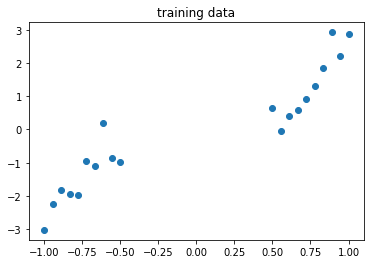

In [5]:
# Number of data points in each of the two segments of the domain
N = 10
# Observation noise variance
noise_variance = 0.1

# Generate toy data
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()

**Exercise 1:** Create 100 bootstrap training datasets from the data and fit a polynomial regression on each. Visualize these polynomials and visualize their 95% predictive interval. 

Is the 95% predictive interval as you expected? Why or why not?

Is the uncertainty expressed by this model desirable? Think about specific tasks that require both a prediction and a predictive uncertainty from your model and then comment on whether or not these uncertainties are suitable for that task.

In [6]:
# Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
poly = PolynomialFeatures(100)

# Make an instance of the LinearRegression to perform regression
linear_model = LinearRegression(fit_intercept=False)

In [7]:
# Number of boostrap polyomial models to fit
trials = 100
# Make a list to record all model predictions
y_test_poly = []

# Bootstrap 100 training sets and fit a polynomial regression model on each
for i in range(trials):

    if i % 10 == 0:
        print('bootstrap:', i)
        
    # Generate a bootstrap sample from the data
    indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
    bootstrap_x = x_train[indices]
    bootstrap_y = y_train[indices]
    
    # Fit a polynomial model
    bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
    bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    linear_model.fit(bootstrap_x_poly, bootstrap_y)

    # Predict on x_test
    y_test = linear_model.predict(bootstrap_x_test_poly)
    y_test_poly.append(y_test)

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


In [8]:
y_test_poly = np.array(y_test_poly)

# Compute the 97.5 th percentile of the posterior predictive predictions
y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

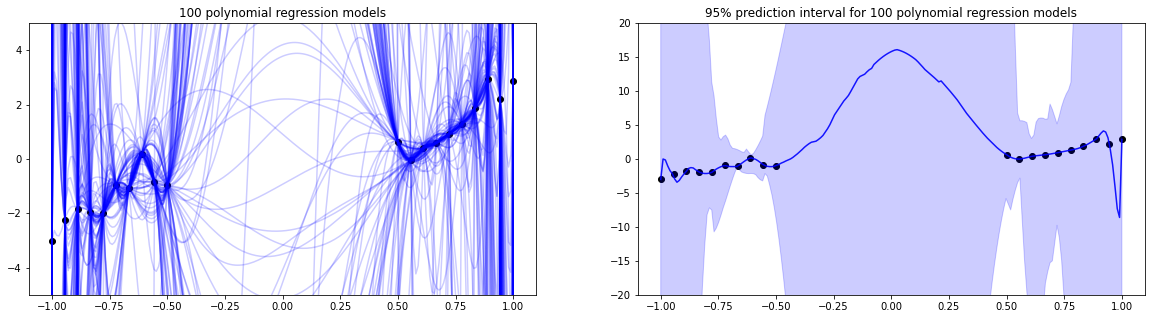

In [9]:
# Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].scatter(x_train, y_train, color='black', label='data')
ax[1].scatter(x_train, y_train, color='black', label='data')

# Plot the 100 polynomial models
for y_poly in y_test_poly:
    ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

ax[0].set_ylim([-5, 5])
ax[0].set_title('{} polynomial regression models'.format(trials))

# Plot 95% predictive interval
ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

ax[1].set_ylim([-20, 20])
ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

plt.show()

Is the 95% predictive interval as you expected? Why or why not?

Is the uncertainty expressed by this model desirable? Think about specific tasks that require both a prediction and a predictive uncertainty from your model and then comment on whether or not these uncertainties are suitable for that task.

** Solution: ** 

It is nice that there is a wider predictive interval in regions where we do not have training data, reflecting more uncertainty in regions where we do not have as much data: from x = -0.50 to 0.50, the predictive interval is wide.  This reflects our uncertainty about this region, where we do not have any training examples.   The very wide 95% predictive intervals, particularly in the data-poor regions is as expected, because we are using high-dimensional basis functions (of degree 10) in relation to the total number of training examples that we have; therefore the model class has high variance.

However, in some real-life scenarios we may wish to learn a model that does not have as high uncertainty/variance in "gap regions" where there is less data.  In this particular example, it appears that the data can be fit using a simple linear model across the gap.  

One scenario where this predictive uncertainty would be desired is a model to predict vibration frequency from physical machinery such as turbine.  In this scenario, it is possible that the true values of the vibration frequency could oscillate or have very high variance in transition phases.  In this scenario, using a model that reflects such uncertainty and can model flexible and large changes in the data is desirable.  

**Exercise 2:** Experiment with changing the number of data points in the toy dataset; experiment also with the polynomial degree. Empirically, how do these choices impact the boostrap uncertainties? Is this what you expect, given your understanding of the properties of MLEs?

** Solution: **

When we increase the number of data points from 10 to 1,000, then the learned models are all identical (i.e. have low variance) in the regions where we have many data points, but have high variance in the data-poor regions.  This is in juxtaposition to when we only had 10 data points, where there was some non-zero variance even still in regions where we had data points.  If we continue to increase the number of data points to 100,000, the prediction intervals gradually decrease to the point where they no longer represent the desired uncertainty in the gap.  As N goes to infinity, it appears that the uncertainty in the gap decreases.  

When we decrease the polynomial degree, the learned predictive intervals are significantly less wide across the entire domain.  In particular, the predictive interval is not significantly wider in the data-poor gap region than in the regions where there are data.  This is as expected, as a third-degree polynomial class has less model variancee.  Decreasing the polynomial degree and consequently decreasing the model's "uncertainty" in the PI may not be desired, particularly in scenarios where modeling uncertainty in data-poor regions is important (such as our vibration frequency example above).

Increasing the polynomial degree widens the predictive interval in the data poor region, reflecting increased uncertainty.  Interestingly increasing the degree decreases the predictive interval in the data-rich regions, as now the model is capable of precisely going through each training example, enabling overfitting to the training set.  This is as expected as increasing the degree increases the varaince of the model class.




**Exercise 3:** Experiment with fitting bootstrap MLE models with $\ell_2$-regularization (i.e. instead of performing linear regression on your polynomial features, perform Ridge regression). Explain the effect of the regularization strength on the boostrap uncertainties. 

*Hint:* You can use the `Ridge` model from `sklearn` for fitting a Ridge regression model.

In [10]:
from sklearn.linear_model import Ridge

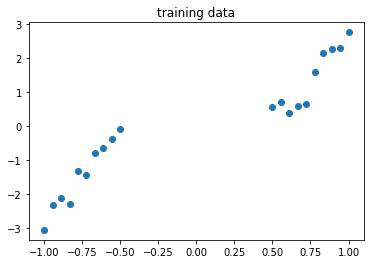

In [11]:
# Number of data points in each of the two segments of the domain
N = 10
# Observation noise variance
noise_variance = 0.1

# Generate toy data
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()

In [12]:
# Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
poly = PolynomialFeatures(10)

# Make an instance of the LinearRegression to perform regression
linear_model = Ridge(alpha= 0.1, fit_intercept=False)

# Number of boostrap polyomial models to fit
trials = 100
# Make a list to record all model predictions
y_test_poly = []

# Bootstrap 100 training sets and fit a polynomial regression model on each
for i in range(trials):

    if i % 10 == 0:
        print('bootstrap:', i)
        
    # Generate a bootstrap sample from the data
    indices = np.random.choice(np.arange(len(x_train)), size=len(x_train))
    bootstrap_x = x_train[indices]
    bootstrap_y = y_train[indices]
    
    # Fit a polynomial model
    bootstrap_x_poly = poly.fit_transform(bootstrap_x.reshape((-1, 1)))
    bootstrap_x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    linear_model.fit(bootstrap_x_poly, bootstrap_y)

    # Predict on x_test
    y_test = linear_model.predict(bootstrap_x_test_poly)
    y_test_poly.append(y_test)

y_test_poly = np.array(y_test_poly)

# Compute the 97.5 th percentile of the posterior predictive predictions
y_test_poly_ub = np.percentile(y_test_poly, 97.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
y_test_poly_mean = np.percentile(y_test_poly, 50.0, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
y_test_poly_lb = np.percentile(y_test_poly, 2.5, axis=0)

bootstrap: 0
bootstrap: 10
bootstrap: 20
bootstrap: 30
bootstrap: 40
bootstrap: 50
bootstrap: 60
bootstrap: 70
bootstrap: 80
bootstrap: 90


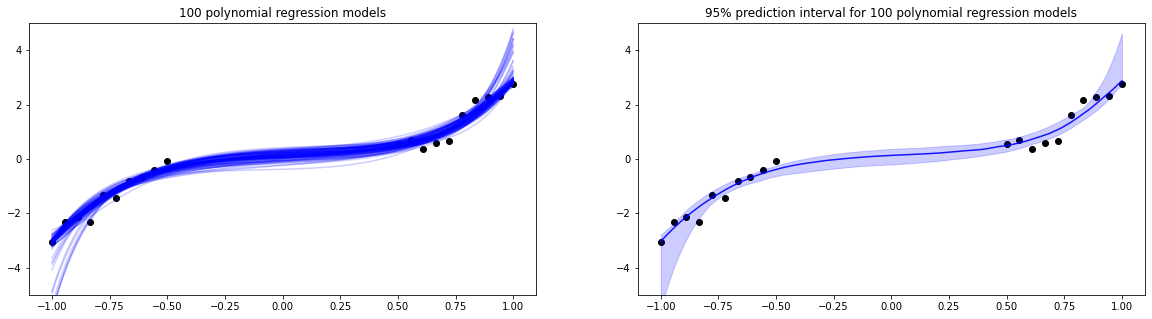

In [13]:
# Visualize these 100 boostrap models and visualize their 95% posterior predictive interval
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].scatter(x_train, y_train, color='black', label='data')
ax[1].scatter(x_train, y_train, color='black', label='data')

# Plot the 100 polynomial models
for y_poly in y_test_poly:
    ax[0].plot(x_test, y_poly, color='blue', alpha=0.2)

ax[0].set_ylim([-5, 5])
ax[0].set_title('{} polynomial regression models'.format(trials))

# Plot 95% predictive interval
ax[1].fill_between(x_test, y_test_poly_ub, y_test_poly_lb, color='blue', alpha=0.2)
ax[1].plot(x_test, y_test_poly_mean, color='blue', alpha=0.9)

ax[1].set_ylim([-5, 5])
ax[1].set_title('95% prediction interval for {} polynomial regression models'.format(trials))

plt.show()

Explain the effect of the regularization strength on the boostrap uncertainties.

** Solution: **

When we use low regularizing strengths (i.e. alphas of [0., 0.1]), the learned model has larger uncertainty:  the PIs are wider, particularly in the data-poor regions.  When we increase the regularizing strength to alphas of 0.5 and 1.0, the PIs decrease and similar models are learned across different bootstrapping trials.  This is expected, as regularization "restricts" the class of models that are learned by penalizing models which have high weight magnitudes.  One thing to note is that Ridge penalizes all of the weight coefficients "equally" by simply adding the L2 norm to the loss.  One alternative to consider would be penalizing the weights for the high-degree values more, as it is these weights that can most directly contribute to the variance of the learned model.  

---
## Problem 2: Bayesian Posterior Predictive Uncertainties

In these exercises we explore posterior predictive uncertaintites from a Bayesian model.

**Exercise 4:** Fit a Bayesian polynomial regression model to the same dataset. Visualize the 95% posterior predictive interval.

Is the uncertainty expressed by this model desirable? Think about specific tasks that require both a prediction and a predictive uncertainty from your model and then comment on whether or not these uncertainties are suitable for that task.

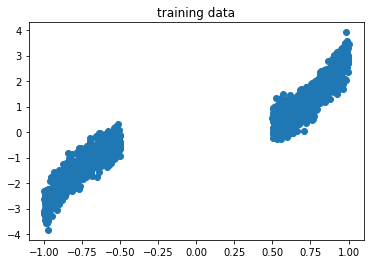

In [37]:
# Number of data points in each of the two segments of the domain
N = 1000
# Observation noise variance
noise_variance = 0.1

# Generate toy data
x_train, y_train, x_test = generate_data(number_of_points=N, noise_variance=noise_variance)

# Plot the training data
plt.scatter(x_train, y_train)
plt.title('training data')
plt.show()

In [38]:
# Make an instance of the PolynomialFeatures model to add polynomial powers to our covariates
poly = PolynomialFeatures(10)

# Fit our PolynomialFeatures to our data and add add polynomial powers to our covariates
x_train_poly = poly.fit_transform(x_train.reshape((-1, 1)))
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

In [39]:
# Define noise level in the data
noise_variance = 0.1

# Define the variance of the prior distribution
prior_variance = 9

# Define the number of samples to take from the posterior
samples = 100

# Get samples from the posterior predictive
posterior_predictions, posterior_predictive_samples = get_posterior_samples(prior_variance, noise_variance, x_train_poly, y_train.reshape((-1, 1)), x_test_poly, samples)

In [40]:
# Compute the 97.5 th percentile of the posterior predictive predictions
pp_upper = np.percentile(posterior_predictive_samples, 97.5, axis=0)

# Compute the 2.5 th percentile of the posterior predictive predictions
pp_lower = np.percentile(posterior_predictive_samples, 2.5, axis=0)

# Compute the 50 th percentile of the posterior predictive predictions
pp_mean = np.mean(posterior_predictive_samples, axis=0)

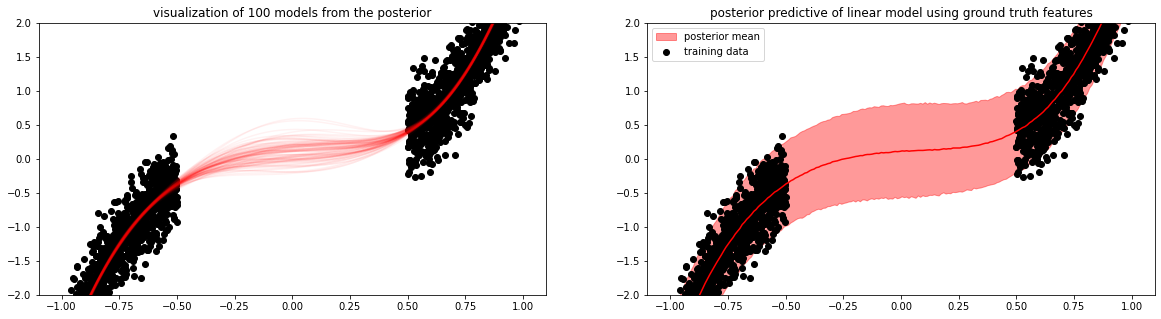

In [41]:
# Visualize the posterior predictive distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].scatter(x_train, y_train, color='black', label='training data') # visualize the training data 

for sample in posterior_predictions:
    ax[0].plot(x_test, sample, color='red', alpha=0.05) # visualize each model from the posterior

ax[0].set_ylim([-2, 2])
ax[0].set_title('visualization of {} models from the posterior'.format(samples))

ax[1].plot(x_test, pp_mean, color='red') # visualize the mean of the posterior predictive
ax[1].fill_between(x_test, pp_upper, pp_lower, color='red', alpha=0.4, label='posterior mean') # visualize the 95% posterior predictive interval
ax[1].scatter(x_train, y_train, color='black', label='training data') # visualize the training data

ax[1].legend(loc='best')
ax[1].set_title('posterior predictive of linear model using ground truth features')
ax[1].set_ylim([-2, 2])
plt.show()

Is the uncertainty expressed by this model desirable? Think about specific tasks that require both a prediction and a predictive uncertainty from your model and then comment on whether or not these uncertainties are suitable for that task.

** Solution: **

The uncertainty expressed is desirable, as the model has wider PIs and therefore higher uncertainty in data-poor regions than in regions where there are training examples.  However, it is worth noting that the Bayesian model has lower predictive uncertainty across all regions in comparison to the frequentist model.  In this example, the choice of the prior variance affects the variance of the posterior predictive distribution.  Our choice of the prior distribution "normalizes" the learned posterior predictive distribution by increasing the likelihood of posteriors that are similar to the prior.  If we were to increase the prior variance, then we would have larger predictive intervals and larger uncertainty in the posterior predictive.

Using a Bayesian model is helpful in scenarios where you wish to explicitly model and set a prior on the uncertainty of your parameters.  For example, if you're modeling a time-series such as high-frequency trading data that can "break" (for example, the system can go down or stop colelcting data for some periods of time), then your system will need to run (and therefore you may not wish to have high model variance in these data-poor regions).  In this scenario, it would still be helpful to be able to use the uncertainty of the model when making decisions - for example, in scenarios where the model has higher uncertainty, you may wish to be more risk-averse.  


**Exercise 5:** Experiment with changing the number of data points in the toy dataset; experiment with the polynomial degree; experiment also with changing the variance of the priors on the parameters. Empirically, how do these choices impact the posterior predictive uncertainties? Is this what you expect, given your understanding of the properties of Bayesian models?

** Solution: **

With a low prior variance, having a lot more data points will not make a big difference (as none of the additional data points are in the missing centre). Hence our uncertainty about the centre will not change much.

With higher variance, there is greater uncrtainty in the parameter estimates as evidenced by wider posterior predictive intervals. In these cases the prior imposes less structure, thus more observations will narrow the bands.


---

## Problem 3: Comparison of Bayesian and Frequentist Uncertainties

**Exercise 6:** As the number of data points grow, do the posterior predictive mean of the Bayesian model and the mean of the boostrap ML models agree? Is this what you expect, given your understanding of the asymptotic properties of Bayesian models?

**Exercise 7:** Based on your experiments, compare boostrap uncertainties from MLE models with posterior predictive uncertainties from Bayesian models. Describe the pros and cons of each approach ***in real-life applications*** (to make your discussion meaningful and concrete, think of specific tasks that require both a prediction and predictive uncertainty).

If you wanted to make sure the bootstrap uncertainties from MLE models align with task-specific desiderata, which aspects of the model should you take care to control? Similarly, if you wanted to make sure the posterior predictive uncertainties from MLE models align with task-specific desiderata, which aspects of the model should you take care to control?

